# Defect Detection Assessment

---
## 1. Introduction

### 1.1 Problem Understanding

**My first step is to clearly understand the assessment task.**  
In this assessment, I have been provided with two datasets:

- **Dataset A**: Manually collected defect detection results (ground‑truth annotations).  
- **Dataset B**: System‑generated defect detection results (model predictions with confidence scores).

**The core objectives are:**

1. **Analyze both datasets** to understand their contents, distributions, and relationships.  
2. **Determine optimal confidence thresholds** for the model’s predictions in Dataset B that balance precision and recall.  
3. **Compute and compare standard classification metrics** (accuracy, precision, recall, F1‑score) for both datasets.  
4. **Propose concrete improvements** for model retraining—covering data quality, preprocessing, model architecture, and augmentation strategies.  
5. **Document my entire process** with screen recording and audio commentary, showing my exploration, questioning, use of AI tools, and rationale at each step.

I will approach this systematically:  
1. Data exploration → 2. Threshold analysis → 3. Metric computation → 4. Recommendations → 5. Video walkthrough.

---

### 1.2 Data Understanding

First and foremost, I will build a conceptual understanding of the domain and the specific datasets.

**What is Defect Detection?**  
Defect detection refers to the automated identification and localization of flaws—such as cracks, scratches, foreign bodies, or missing components—on manufactured products or materials. 

The provided data seems to come from a medical or biological context. The defect class "Mononukleäre Zelle" is German for "Mononuclear Cell" (specifically, a Peripheral Blood Mononuclear Cell). These are key cells in the human immune system, like lymphocytes and monocytes. Therefore, this is likely a system for analyzing blood-sample images to identify specific types of cells, which could be for disease diagnosis or medical research. The "defects" are the cells of interest.

Typically:

- **Ground-truth annotations (anno_df.csv)** are created by human inspectors who mark each defect’s location (e.g., bounding polygon) and class label.  
- **Model predictions (pred_df.csv)** assign each detected region a defect class and a confidence score indicating the model’s certainty.

**What do the Datasets Represent?**  
- **Dataset A (Annotations)**  
  - Contains one record per annotated defect.  
  - Fields include:
    - *filename / image_id:* Identifies the source image.
    - *label:* The specific type of cell, in this case, "Mononukleäre Zelle".
    - xy, x, y: These columns define the precise location and shape of the cell on the image, likely as a polygon or bounding box.

- **Dataset B (Predictions)**  
  - Contains one record per predicted defect.  
  - Fields include: 
    - *image_id:* Links the prediction back to a specific image.
    - *prediction_class:* The class the model predicted (e.g., "Defect").
    - *confidence:* This is a crucial field. It's a number between 0 and 1 representing how "sure" the model is about its prediction.
    - *xy:* The location and shape of the predicted defect.

---

### 1.3 Overall Analysis Plan (High‑Level)

After clearly understand the task, my next step is my planned workflow:

1. **Data Loading & Inspection**  
   - Load both CSVs and inspect shapes, columns, and sample rows.  
   - Check for missing values, duplicates, and coordinate format consistency.

2. **Exploratory Statistics & Visualizations**  
   - Class distribution histograms for ground‑truth vs. predictions.  
   - Confidence‐score distribution plot.  
   - Summary of image counts and defect counts per image.

3. **Matching Logic Definition**  
   - Define an Intersection over Union (IoU) based matching function to pair predictions with annotations.

4. **Threshold Sweep & Metric Calculation**  
   - Evaluate metrics (precision, recall, F1, accuracy) across a range of confidence thresholds.  
   - Identify optimal thresholds (e.g. maximize F1 or meet a precision/recall requirement).

5. **Comparative Analysis**  
   - Compare performance metrics between Dataset A and Dataset B at their respective thresholds.

6. **Recommendations**  
   - Propose targeted improvements in data collection, preprocessing, model training, and augmentation.

---

*Next,* I will start **Step 1: Data Loading & Inspection** using code, beginning with importing necessary libraries and loading the CSV files.


## 2. Data Analysis and Exploration

In [1]:
# import basic libraries
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# get working directory
sys.path.append(os.path.abspath('..'))

# get modules

from scripts.data_preprocessing import *

### Load DataSet

In [2]:
anno_df_path, pred_df_path = '../data/anno_df.csv', '../data/pred_df.csv'
anno_df, pred_df = load_datasets(anno_df_path, pred_df_path)

Loading Datasets...
Successfully loaded 'anno_df.csv' and 'pred_df.csv'.



### Exploring the Ground Truth Data (anno_df)

In [3]:
# Data preview: load the first five raw of the data
anno_df.head()

,filename,image_id,id,defect_class_id,label,xy,x,y
0,1g_04.png,624,175683,7,Mononukleäre Zelle,"1354,1377.48,1330.52,1389.22,1330.52,1412.699,...","[1354.0, 1330.52, 1330.52, 1350.087, 1357.913,...","[1377.48, 1389.22, 1412.699, 1424.439, 1420.52..."
1,1g_04.png,624,175664,7,Mononukleäre Zelle,"223.058,1804.029,199.578,1800.116,191.751,1815...","[223.058, 199.578, 191.751, 203.491, 223.058, ...","[1804.029, 1800.116, 1815.769, 1831.422, 1835...."
2,1g_04.png,624,175634,7,Mononukleäre Zelle,"1549.665,1005.717,1545.751,1013.543,1541.838,1...","[1549.665, 1545.751, 1541.838, 1541.838, 1557....","[1005.717, 1013.543, 1021.37, 1037.023, 1037.0..."
3,1g_04.png,624,175654,7,Mononukleäre Zelle,"661.347,1678.803,637.867,1667.064,614.387,1674...","[661.347, 637.867, 614.387, 622.214, 630.04, 6...","[1678.803, 1667.064, 1674.89, 1698.37, 1694.45..."
4,1g_04.png,624,175633,7,Mononukleäre Zelle,"1784.462,1897.948,1796.202,1886.208,1804.029,1...","[1784.462, 1796.202, 1804.029, 1780.549, 1772....","[1897.948, 1886.208, 1870.555, 1858.815, 1862...."


In [4]:
analyze_ground_truth_data(anno_df)


Analysis of Ground Truth Data (anno_df)

Shape: (3648, 8)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3648 entries, 0 to 3647
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         3648 non-null   object
 1   image_id         3648 non-null   int64 
 2   id               3648 non-null   int64 
 3   defect_class_id  3648 non-null   int64 
 4   label            3648 non-null   object
 5   xy               3648 non-null   object
 6   x                3648 non-null   object
 7   y                3648 non-null   object
dtypes: int64(3), object(5)
memory usage: 256.5+ KB

Missing Values:
filename           0
image_id           0
id                 0
defect_class_id    0
label              0
xy                 0
x                  0
y                  0
dtype: int64

Summary Statistics:
          image_id            id  defect_class_id
count  3648.000000  3.648000e+03           3648.0

### Exploring the Prediction Data (pred_df)

In [5]:
pred_df.head()

,image_id,prediction_id,confidence,polygon_id,prediction_class,xy
0,3165,23699,0.431523,1937097,Defect,"37.578460693359375,13.887542724609375,37.31016..."
1,3165,23699,0.603884,1937098,Defect,"231.45407104492188,9.646164820744442,225.45407..."
2,3165,23699,0.244653,1937099,Defect,"318.3146711077009,33.736045837402344,316.76688..."
3,3165,23699,0.916268,1937100,Defect,"395.9158020019531,82.97906857445126,387.915802..."
4,3165,23699,0.366087,1937101,Defect,"337.0517883300781,84.71218928584346,332.051788..."



Analysis of Prediction Data (pred_df)

Shape: (7118, 6)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
Index: 7118 entries, 0 to 7117
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_id          7118 non-null   int64  
 1   prediction_id     7118 non-null   int64  
 2   confidence        7118 non-null   float64
 3   polygon_id        7118 non-null   int64  
 4   prediction_class  7118 non-null   object 
 5   xy                7118 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 389.3+ KB

Missing Values:
image_id            0
prediction_id       0
confidence          0
polygon_id          0
prediction_class    0
xy                  0
dtype: int64

Object type summary statistics:
       prediction_class                                                 xy
count              7118                                               7118
unique                1              

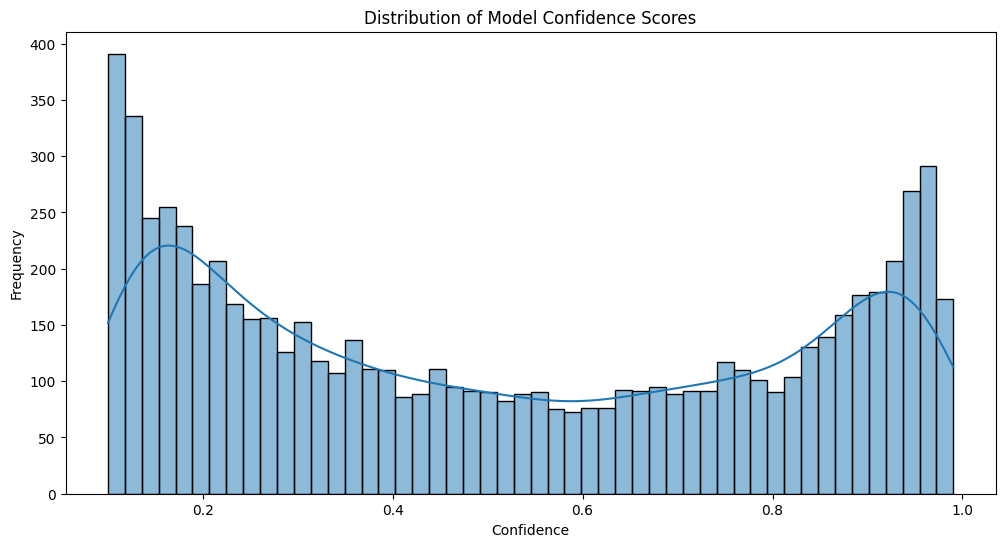

The plot above shows the distribution of the model's confidence scores across all predictions.


In [6]:
analyze_prediction_data(pred_df)

### Comparative Analysis
- comparison between the two dataset: anno_df and pred_df


--- Comparative Analysis: Ground Truth vs. Predictions ---

Number of unique images in Annotation data: 48
Number of unique images in Prediction data: 48

(a) Comparison of Annotation vs. Prediction Counts per Image (First 10):
          num_annotations  num_predictions  difference
image_id                                              
624                    75              111          36
627                   128              194          66
631                    78              131          53
645                    53              103          50
646                    92              181          89
648                    64              151          87
653                     8               14           6
654                    26               57          31
655                    42               99          57
1177                  105              219         114

(b) Summary statistics for the difference (Predictions - Annotations):
count     48.000000
mean      72.291667

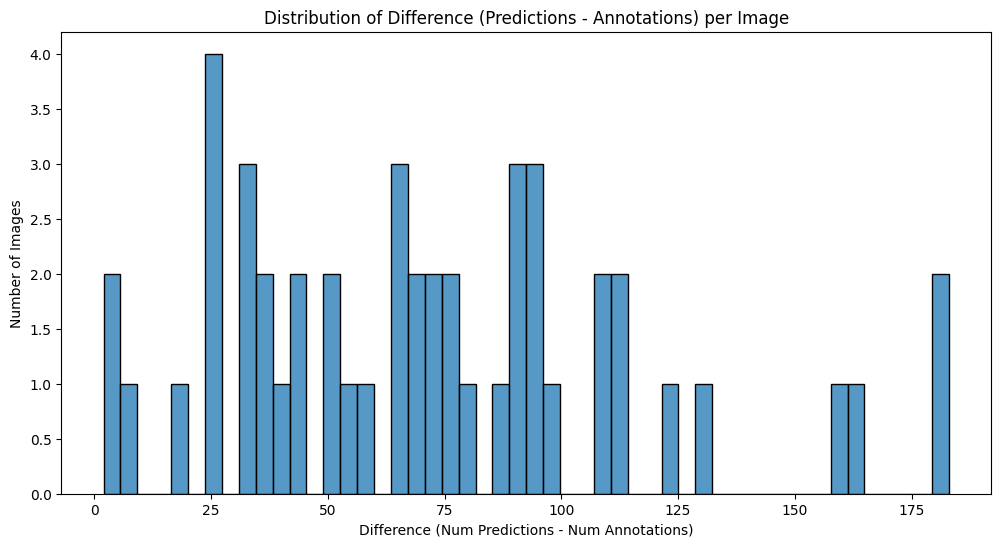

The plot above shows how often the model over-predicts (positive values) or under-predicts (negative values).
A value of 0 means the model predicted the exact same number of defects as the human expert for that image.


In [7]:
compare_datasets(anno_df, pred_df)

## 3. Dataset discussion 

***Note:*** When we see the same `image_id` appearing in multiple rows, that tells us there are **multiple defect instances** annotated or predicted within the same source image. In other words:

This multiplicity is expected: a single product photo can contain many defects, and our later matching logic (e.g. via IoU) will align each predicted region to a corresponding ground‑truth region (or declare it a false positive).

---

### Column Descriptions

**anno_df (Dataset A: Ground‑Truth Annotations)**

| Column             | Type           | Description                                                                                   |
|--------------------|----------------|-----------------------------------------------------------------------------------------------|
| filename         | string         | The image file name (e.g. "1g_04.png")                                                      |
| image_id         | integer        | Unique numeric ID for each image                                                               |
| id               | integer        | Unique ID of each annotation record                                                            |
| defect_class_id  | integer        | Numeric code for the defect category (e.g. 7)                                                  |
| label            | string         | Human‑readable defect class name (e.g. "Mononukleäre Zelle")                                 |
| xy               | string         | Comma‑separated list of alternating x,y polygon vertices ("x1,y1,x2,y2,...")                 |
| x                | string/list    | Comma‑separated or parsed Python list of the x‑coordinates of the polygon vertices             |
| y                | string/list    | Comma‑separated or parsed Python list of the y‑coordinates of the polygon vertices             |


### pred_df (Dataset B: Model Predictions)

| Column             | Type           | Description                                                                                   |
|--------------------|----------------|-----------------------------------------------------------------------------------------------|
| image_id         | integer        | Unique numeric ID matching the source image                                                   |
| prediction_id    | integer        | Unique ID for each predicted region                                                           |
| confidence       | float (0–1)    | Model’s confidence score for this detection                                                   |
| polygon_id       | integer        | ID for the predicted polygon (may match one of several for a given prediction_id)          |
| prediction_class | string         | Defect class label predicted by the model (e.g. "Defect" or possibly more specific labels)  |
| xy               | string         | Comma‑separated list of alternating x,y polygon vertices ("x1,y1,x2,y2,...")                 |



## 4. Image Matching

My next step is to perform the critical task of matching the model's predictions to the ground truth annotations. This allows me to classify each prediction aa: 
* True Positive (TP)—a correct detection 
* False Positive (FP)—an incorrect detection. 
* It also allows me to count False Negatives (FN), which are real defects that the model missed entirely.

**My methodology is as follows:**
1. Polygon Parsing: First defined a robust utility function to parse the xy coordinate strings from the CSV files into a structured list of (x, y) tuples

  - *Polygon* is simply the shape we use to mark the exact area of each defect in an image.

  - Intersection over Union (IoU): I implemented a function to calculate the IoU between two polygons.
    * IoU= Area of Union / Area of Overlap
​
3. Matching Algorithm: I processed the data on a per-image basis. For each image, I constructed an "IoU matrix" containing the IoU score for every possible pair of predictions and ground truth annotations.

  * A prediction is considered a potential match for a ground truth annotation if their IoU is greater than or equal to a standard threshold of 0.5.
  * To prevent a single real defect from being counted as multiple correct detections, each ground truth annotation can only be matched to one prediction (the one with the highest IoU).
  * A prediction that is successfully matched to a ground truth annotation is classified as a True Positive (TP).
  * A prediction that is not matched to any ground truth annotation (or whose best IoU is below the 0.5 threshold) is classified as a False Positive (FP).
  * A ground truth annotation that is not matched by any suitable prediction is counted as a False Negative (FN).
 


In [8]:
# import the module
from scripts.image_matching import *

Successfully reloaded datasets.

Starting Prediction-to-Annotation Matching


Processing Images:   0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
#Create the Final Matched DataFrame 
print("\nCreating Final Matched DataFrame ")
matched_df = pd.DataFrame(results)



Creating Final Matched DataFrame 


In [10]:
# Calculate total False Negatives
total_gt = len(anno_df)
total_tp = len(matched_df[matched_df['match_type'] == 'TP'])
total_fp = len(matched_df[matched_df['match_type'] == 'FP'])
total_fn = total_gt - total_tp

print(f"\nTotal Predictions Processed: {len(pred_df)}")
print(f"True Positives (TP): {total_tp}")
print(f"False Positives (FP): {total_fp}")
print(f"Total False Negatives (FN): {total_fn}")
print(f"(FNs are ground truth objects the model failed to detect with IoU >= {IOU_THRESHOLD})")


Total Predictions Processed: 7118
True Positives (TP): 3111
False Positives (FP): 4007
Total False Negatives (FN): 537
(FNs are ground truth objects the model failed to detect with IoU >= 0.5)


In [11]:
print("\n(a) Head of the Matched DataFrame:")
print(matched_df.head())

print("\n(b) Description of the Matched DataFrame:")
print(matched_df.describe())


(a) Head of the Matched DataFrame:
   image_id  confidence       iou match_type
0      2304    0.939793  0.908260         TP
1      2304    0.738525  0.856571         TP
2      2304    0.954028  0.850175         TP
3      2304    0.977104  0.833511         TP
4      2304    0.967156  0.817415         TP

(b) Description of the Matched DataFrame:
          image_id   confidence          iou
count  7118.000000  7118.000000  7118.000000
mean   1951.781540     0.512246     0.343534
std     813.485715     0.302539     0.392683
min     624.000000     0.100062     0.000000
25%    1455.000000     0.218224     0.000000
50%    2021.000000     0.468183     0.000000
75%    2324.000000     0.820323     0.784058
max    3165.000000     0.990468     0.936462


---
***Note:***
* This 'matched_df' is now the foundation for our threshold analysis.
* Each row is a prediction, classified as TP or FP, with its associated confidence and IoU.
---

## Optimal Confidence Thresholds Calculation 

In [12]:
# Import modules 
from scripts.confidence_thresholds import *

Successfully loaded annotation data. 'matched_df' is ready.


In [13]:
print("\nAnalysis Results")
print(f"Optimal Confidence Threshold: {optimal_threshold_data['threshold']:.2f}")


Analysis Results
Optimal Confidence Threshold: 0.38


In [14]:
print(f"Metrics at Optimal Threshold:")
print(f"  F1-Score:  {optimal_threshold_data['f1_score']:.4f}")
print(f"  Precision: {optimal_threshold_data['precision']:.4f}")
print(f"  Recall:    {optimal_threshold_data['recall']:.4f}")

Metrics at Optimal Threshold:
  F1-Score:  0.6790
  Precision: 0.6444
  Recall:    0.7177


In [15]:
print("At this threshold, the model achieved:")
print(f"  - True Positives (Correct Detections):   {int(optimal_threshold_data['tp'])}")
print(f"  - False Positives (Incorrect Detections): {int(optimal_threshold_data['fp'])}")
print(f"  - False Negatives (Missed Defects):        {int(optimal_threshold_data['fn'])}")

At this threshold, the model achieved:
  - True Positives (Correct Detections):   2618
  - False Positives (Incorrect Detections): 1445
  - False Negatives (Missed Defects):        1030


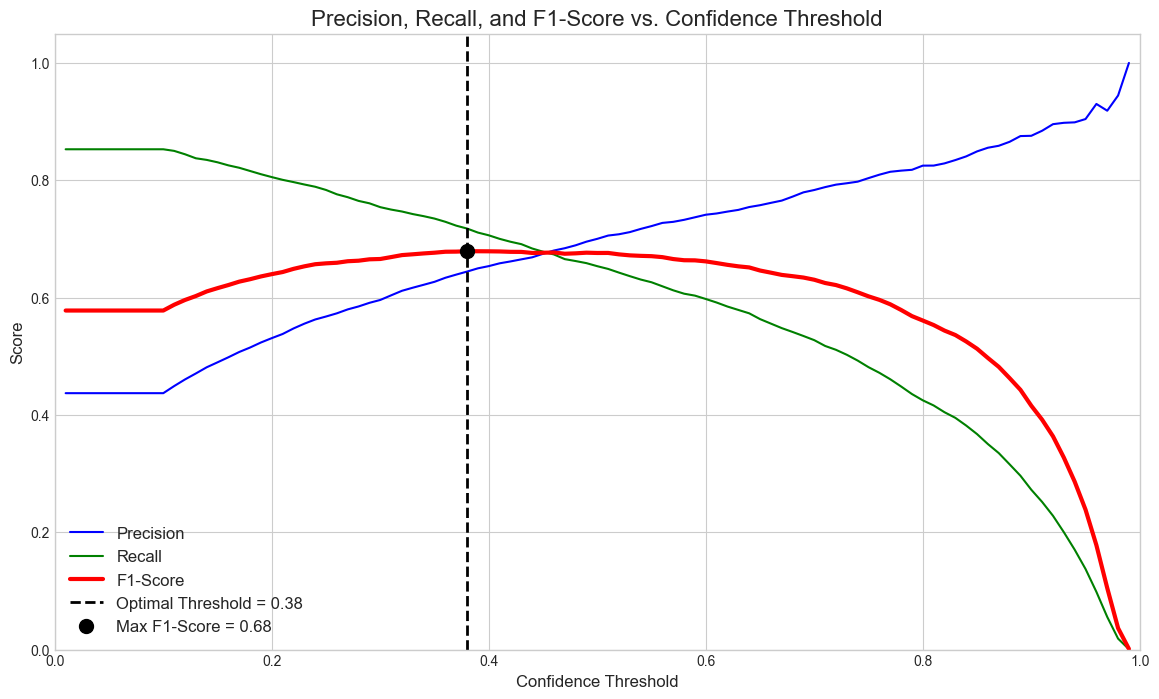

In [ ]:
# Visualize the re
visualize_the_results()

---
***Note:***
* The plot above visually demonstrates the trade-off between precision and recall.
* The optimal threshold is found at the peak of the F1-Score curve.
---